# <center>House Prices</center>
With explanatory variables describing (almost) every aspect of residential homes in Ames, lowa. Using this dataset predict the final price of each home.

In [35]:
# Code for showing toggle button for showing/hiding the code
from IPython.display import HTML,Image,display
HTML('''
<script>
code_show=true;
function code_toggle(){
if (code_show){
$('div.input').hide();
$("#btn_toggle").val("Show Code");
}else{
$('div.input').show();
$("#btn_toggle").val("Hide Code");
}
code_show= !code_show;
}
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
<form action="javascript:code_toggle()">
<input style = "float:right" type="submit" id="btn_toggle" value="Hide Code">
''')


In [9]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [10]:
#Visualization settings
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

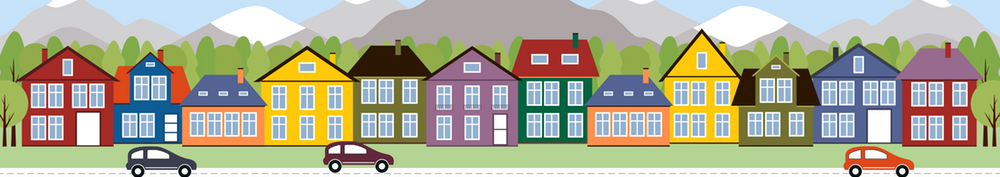

In [12]:
Image('housesbanner.png')

In [17]:
df_train=pd.read_csv('train.csv')
print ("Training data loaded")

Training data loaded


## <center>Dataset description</center>

In [18]:
print ("Sample dataframe:\n")
df_train.head(3)

Sample dataframe:



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [22]:
print (f"Initial data frame contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")

Initial data frame contains 1460 rows and 81 columns.


In [101]:
col_tags ="<ol>" + "".join([f"<li><h4>{col}</h4></li>" for col in df_train.columns]) + "</ol>"
display(HTML('<h3>Feature names:</h3>'))
display(HTML(col_tags))

In [103]:
print ("Dataset information :\n")
df_train.info()

Dataset information :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null 

<h3 style='background-color:yellow'>
    3 float columns <br>
    35 integer columns <br>
    43 String columns
    </h3>

In [211]:
val=df_train.isnull().sum()
df=pd.DataFrame(val,columns=["NullCount"]).query('NullCount != 0')
df=pd.DataFrame({"Features": df.index,
             "NullCount": df.NullCount.values})
df.sort_values(by="NullCount",inplace=True,ascending=False)

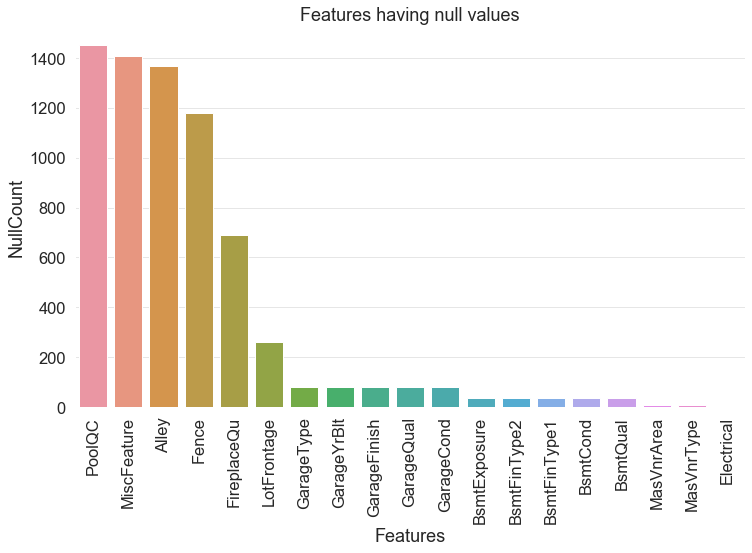

In [210]:
sns.barplot(data=df,x="Features",y="NullCount");
plt.xticks(rotation=90);
plt.title("Features having null values");

In [212]:
df

,Features,NullCount
16,PoolQC,1453
18,MiscFeature,1406
1,Alley,1369
17,Fence,1179
10,FireplaceQu,690
0,LotFrontage,259
11,GarageType,81
12,GarageYrBlt,81
13,GarageFinish,81
14,GarageQual,81


In [215]:
print (f"Number of features having null values: {df.shape[0]}")

Number of features having null values: 19


## <center> Features - Exploratory Data Analysis</center>

### SalePrice - Target Feature

In [261]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

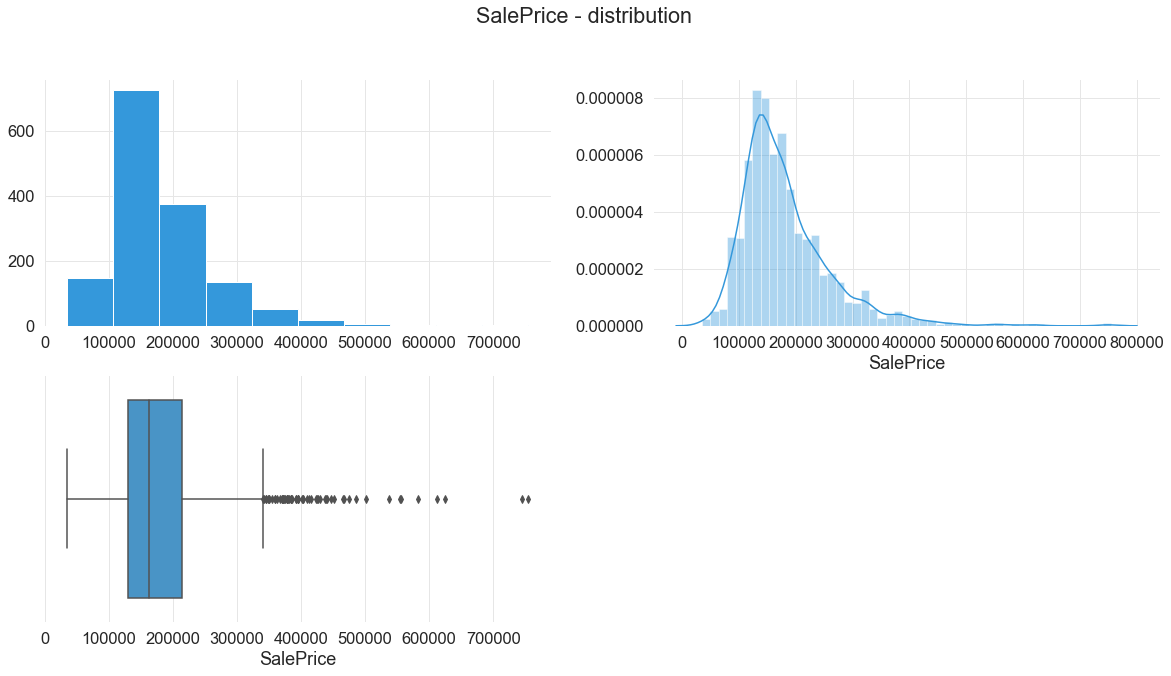

In [260]:
plt.figure(figsize=(20,10));
plt.subplot(2,2,1)
plt.hist(x=df_train.SalePrice);
plt.subplot(2,2,2)
sns.distplot(df_train.SalePrice);
plt.subplot(2,2,3)
sns.boxplot(df_train.SalePrice);
plt.suptitle("SalePrice - distribution");

In [258]:
print (f"Skewness in data : {df_train.SalePrice.skew()}")

Skewness in data : 1.8828757597682129


<h3 style='background-color:yellow'>
Continuous variable <br>
Positively skewed distribution.<br>
Presence of outliers.
</h3>

### 1. MSSubClass
Identifies the type of dwelling involved in the sale.<br>
 20	1-STORY 1946 & NEWER ALL STYLES<br>
        30	1-STORY 1945 & OLDER<br>
        40	1-STORY W/FINISHED ATTIC ALL AGES<br>
        45	1-1/2 STORY - UNFINISHED ALL AGES<br>
        50	1-1/2 STORY FINISHED ALL AGES<br>
        60	2-STORY 1946 & NEWER<br>
        70	2-STORY 1945 & OLDER<br>
        75	2-1/2 STORY ALL AGES<br>
        80	SPLIT OR MULTI-LEVEL<br>
        85	SPLIT FOYER<br>
        90	DUPLEX - ALL STYLES AND AGES<br>
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER<br>
       150	1-1/2 STORY PUD - ALL AGES<br>
       160	2-STORY PUD - 1946 & NEWER<br>
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER<br>
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES<br>

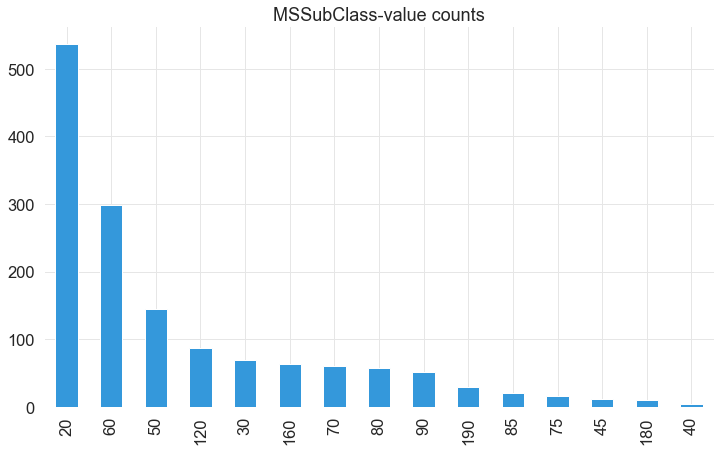

In [220]:
df_train.MSSubClass.value_counts().plot.bar();
plt.title("MSSubClass-value counts");

<h3 style='background-color:yellow'>
Categoical variable.
</h3>

### 2. MSZoning       
Identifies the general zoning classification of the sale.
    A	Agriculture <br>
       C	Commercial<br>
       FV	Floating Village Residential<br>
       I	Industrial<br>
       RH	Residential High Density<br>
       RL	Residential Low Density<br>
       RP	Residential Low Density Park <br>
       RM	Residential Medium Density<br>

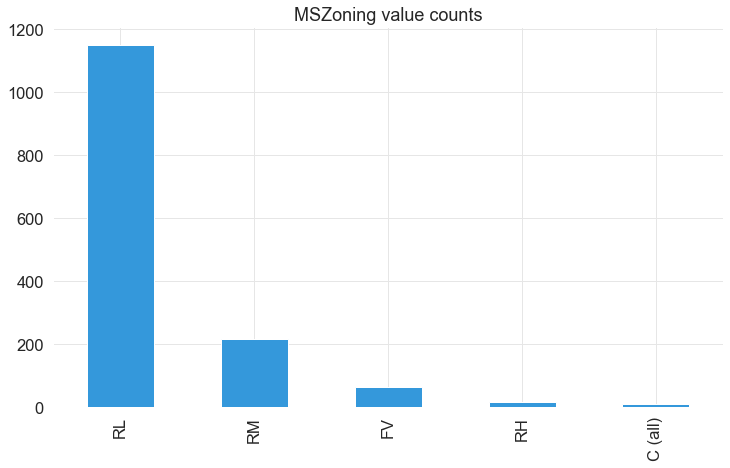

In [224]:
df_train.MSZoning.value_counts().plot.bar();
plt.title("MSZoning value counts");

<h3 style='background-color:yellow'>
Categorical variable.
</h3>

### 3. LotFrontage    
Linear feet of street connected to property

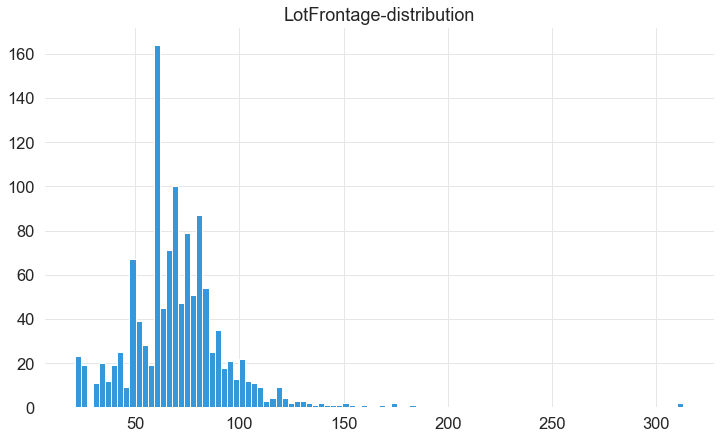

In [240]:
plt.hist(x=df_train.LotFrontage,bins=100);
plt.title("LotFrontage-distribution");

In [239]:
print ("Descriptive statistics:")
df_train.LotFrontage.describe()

Descriptive statistics:


count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

<h3 style='background-color:yellow'>
Continuous variable. <br>
Missing values present.
</h3>

## 4. LotArea
Lot size in square feet

In [262]:
df_train.LotArea.describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

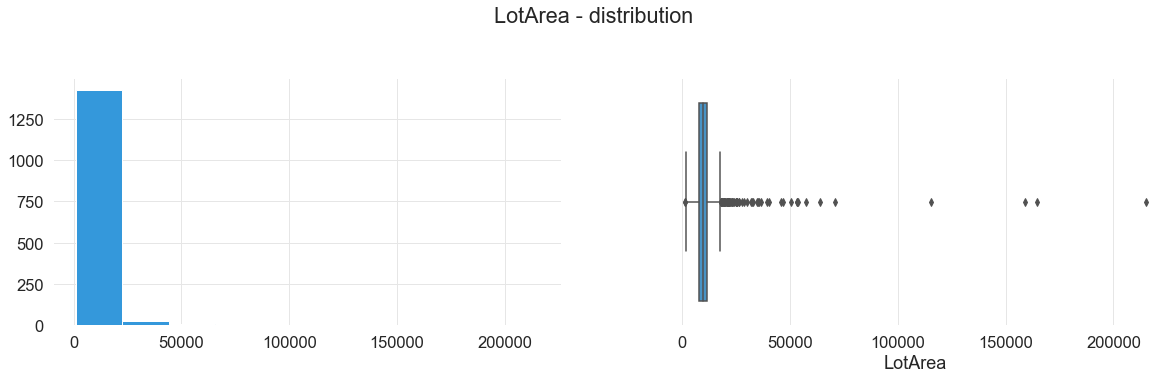

In [266]:
plt.figure(figsize=(20,10));
plt.subplot(2,2,1);
plt.hist(df_train.LotArea);
plt.subplot(2,2,2);
sns.boxplot(df_train.LotArea);
plt.suptitle("LotArea - distribution");